## 書籍評価モデル

<a href="https://colab.research.google.com/github/makaishi2/python_bayes_intro/blob/main/sample-notebooks/%E6%9B%B8%E7%B1%8D%E8%A9%95%E4%BE%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 共通処理

In [1]:
#%matplotlib inline
# 日本語化ライブラリ導入
#!pip install japanize-matplotlib | tail -n 1

In [2]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np
# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt
# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib
# pandas用ライブラリ
import pandas as pd
# データフレーム表示用関数
from IPython.display import display
# seaborn
import seaborn as sns
# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode='fixed')
# 方眼表示ON
plt.rcParams['axes.grid'] = True
# データフレームでの表示精度
pd.options.display.float_format = '{:.3f}'.format
# データフレームですべての項目を表示
pd.set_option("display.max_columns",None)

In [3]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.11.0
Running on ArViz v0.17.1


### データ読み込み

In [4]:
# データ読み込み
fn = 'https://github.com/makaishi2/sample-data/raw/master/data/book_scores.xlsx'
df = pd.read_excel(fn, index_col=[0])

# 重みベクトル(平均スコア算出で利用)
weights = np.array([5, 4, 3, 2, 1])

### データ確認

#### 表データの確認

In [5]:
display(df)

,score5,score4,score3,score2,score1
book,,,,,
ベイズ推論「超」入門,7,2,0,0,0
Pythonプログラミングとデータ分析,12,3,0,1,0
PyTorch &深層学習プログラミング,63,17,13,4,0
Pythonで儲かるAIをつくる,126,60,48,7,10
ディープラーニングの数学,116,32,39,10,13
Python自然言語処理入門,8,2,4,4,5
Watson Studioで始める機械学習・深層学習,3,2,1,0,2


#### グラフ表示

 #### インデックスリスト作成

In [6]:
# 列インデックス
scores = list(df.columns)
n_scores = len(scores)
print(f'列インデックス: {scores}')
ｐｒint(f'列数: {n_scores}')

# 行インデックス
books = list(df.index)
print(f'行インデックス: {books}')

列インデックス: ['score5', 'score4', 'score3', 'score2', 'score1']
列数: 5
行インデックス: ['ベイズ推論「超」入門', 'Pythonプログラミングとデータ分析 ', 'PyTorch &深層学習プログラミング', 'Pythonで儲かるAIをつくる', 'ディープラーニングの数学', 'Python自然言語処理入門', 'Watson Studioで始める機械学習・深層学習']


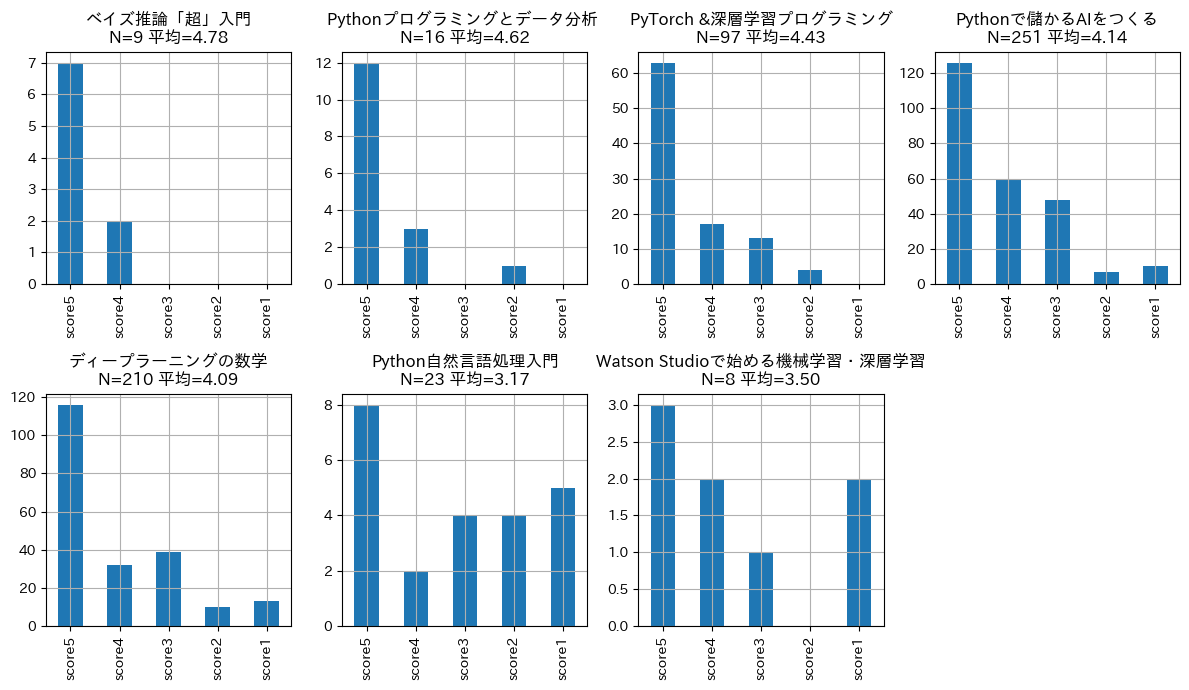

In [7]:
# グラフ描画用各種設定
plt.rcParams['figure.figsize'] = (12, 7)
fig, axes = plt.subplots(2, 4)
axes = axes.reshape(-1)
plt.rcParams["font.size"] = 10

for i, book in enumerate(books):
    # 特定書名の件数抽出
    counts = df.loc[book]

    # 合計レビュー数
    sum = counts.sum()

    # 平均スコア
    ave = counts@weights/sum

    # 描画対象の選定
    ax = axes[i]

    # 棒グラフ表示
    counts.plot.bar(ax=ax)
    ax.set_title(f'{book}\nN={sum} 平均={ave:.02f}')

# 最後の領域は空白に設定
ax = axes[-1]; ax.set_xticks([]); ax.set_yticks([]); ax.axis('off')

#　全体レイアウトの調整
plt.tight_layout()
plt.show()

### 確率モデル構築

#### 特定の書籍用データ準備

In [8]:
book = books[0]
counts = df.loc[book]
sum = counts.sum()

print(f'書名: {book}')
print(f'スコア別レビュー件数:\n{counts}')
print(f'合計レビュー件数: {sum}')

書名: ベイズ推論「超」入門
スコア別レビュー件数:
score5    7
score4    2
score3    0
score2    0
score1    0
Name: ベイズ推論「超」入門, dtype: int64
合計レビュー件数: 9


 #### 確率モデル定義

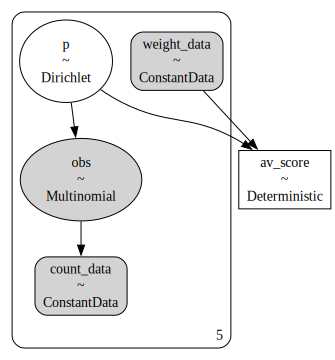

In [9]:
# スコア用インデックス定義
coords = {'score': scores}

# コンテキスト用インスタンス生成
model1 = pm.Model(coords=coords)

# 確率モデルのコンテキスト宣言
with model1:
    # スコア別レビュー件数用変数
    count_data = pm.ConstantData('count_data', counts)

    # 平均スコア算出用配列
    weight_data = pm.ConstantData('weight_data', weights)

    # 多項分布の事前分布をディリクレ分布で行う
    p = pm.Dirichlet('p', a=np.ones(n_scores))

    # 観測値の設定は多項分布で行う
    obs = pm.Multinomial('obs', p=p, n=sum, observed=count_data)

    # 平均スコアの算出結果
    av_score = pm.Deterministic('av_score', p@weight_data)

# 作成した確率モデルの可視化
g = pm.model_to_graphviz(model1)
display(g)

### サンプリング・評価

#### サンプリングと可視化

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


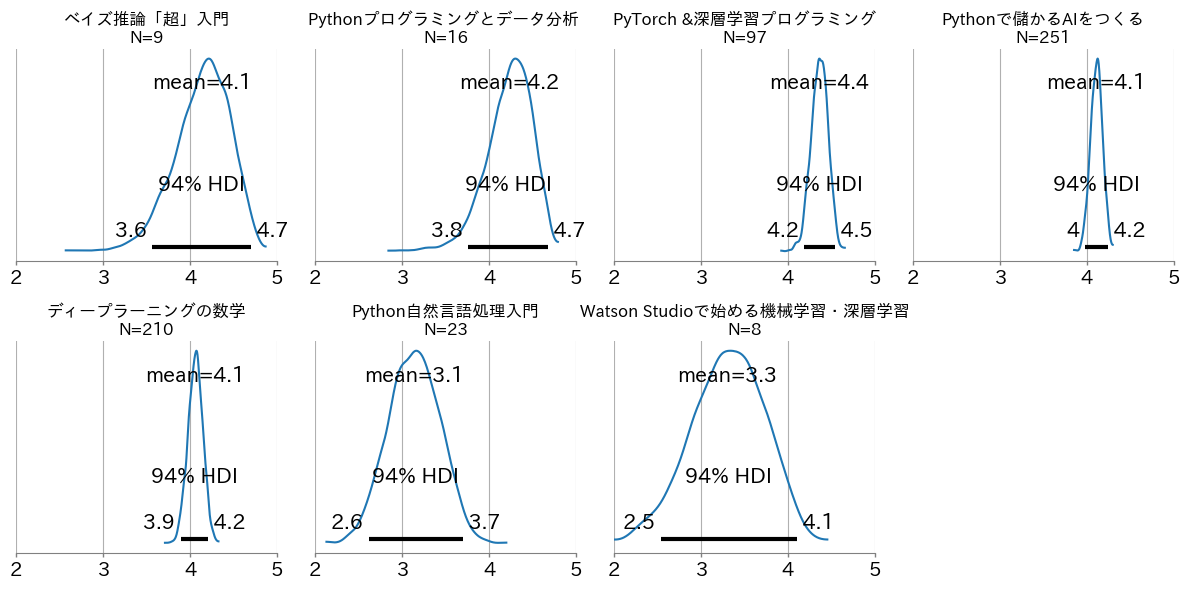

In [10]:
# グラフ描画用各種設定
plt.rcParams['figure.figsize'] = (12, 6)
fig, axes = plt.subplots(2, 4)
axes = axes.reshape(-1)
plt.rcParams["font.size"] = 10

# 全体サマリー表の準備
all_summary = pd.DataFrame(None)

# サンプリング・評価は７書籍まとめて行う
for i, book in enumerate(books):
    counts = df.loc[book]
    ax = axes[i]
    sum = counts.sum()

    # スコア用インデックス定義
    coords = {'score': scores}

    # コンテキスト用インスタンス生成
    model1 = pm.Model(coords=coords)

    # 確率モデルのコンテキスト宣言
    with model1:
        # スコア別レビュー件数用変数
        count_data = pm.ConstantData('count_data', counts)

        # 平均スコア算出用配列
        weight_data = pm.ConstantData('weight_data', weights)

        # 多項分布の事前分布をディリクレ分布で定義
        p = pm.Dirichlet('p', a=np.ones(n_scores))

        # 観測値の設定は多項分布で行う
        obs = pm.Multinomial('obs', p=p, n=sum, observed=count_data)

        # 平均スコアの算出結果
        av_score = pm.Deterministic('av_score', p@weight_data)

        # サンプリング
        idata1 = pm.sample(random_seed=42)

    # サンプリング結果分析
    # 可視化
    az.plot_posterior(idata1, var_names=['av_score'], ax=ax)
    ax.set_title(f'{book}\nN={sum}')
    ax.set_xlim(2,5)

    # 集計表データ作成
    summary = az.summary(idata1, var_names=['av_score'])
    summary.insert(0, '書名', book)
    summary.insert(1, '全体レビュー件数', sum)
    all_summary = pd.concat([all_summary, summary])

# 最後の領域は空白に設定
ax = axes[-1]
ax.set_xticks([]); ax.set_yticks([]); ax.axis('off')

# レイアウトの整形
plt.tight_layout()
plt.show()

#### 表形式の集計

In [11]:
all_summary = all_summary.reset_index(drop=True)
all_sum1 = all_summary.set_index('書名')

# 単純平均の計算
df_ave = df.apply(lambda x: x@weights/x.sum(), axis=1)
df_ave.name = '単純平均'

# 結合
all_sum2 = pd.concat([df_ave, all_sum1], axis=1)

# 整形
all_sum3 = all_sum2.copy()
all_sum3 = all_sum3.iloc[:,:6]
all_sum3 = all_sum3[['全体レビュー件数','単純平均','mean','hdi_3%','hdi_97%','sd']]
all_sum3.columns = [
    '全体レビュー件数','単純平均','ベイズ平均','hdi_3%','hdi_97%','ベイズ偏差'
]

display(all_sum3)

,全体レビュー件数,単純平均,ベイズ平均,hdi_3%,hdi_97%,ベイズ偏差
ベイズ推論「超」入門,9,4.778,4.140,3.566,4.696,0.317
Pythonプログラミングとデータ分析,16,4.625,4.231,3.760,4.680,0.263
PyTorch &深層学習プログラミング,97,4.433,4.363,4.185,4.541,0.097
Pythonで儲かるAIをつくる,251,4.135,4.110,3.982,4.240,0.068
ディープラーニングの数学,210,4.086,4.061,3.891,4.211,0.086
Python自然言語処理入門,23,3.174,3.137,2.618,3.696,0.293
Watson Studioで始める機械学習・深層学習,8,3.500,3.304,2.536,4.101,0.423
